# ADR Code Synth - Workflow Testing Notebook

This notebook demonstrates and tests the ADR (Architecture Decision Record) generation workflow.

## Overview

The ADR Code Synth application uses LangGraph to orchestrate a multi-step workflow that:
1. **Generates architectural context** from source code
2. **Analyzes Terraform files** for infrastructure patterns (minor and major versions)
3. **Validates with source code** to ensure accurate analysis
4. **Compares architectures** between versions
5. **Generates ADRs** documenting key architectural decisions

## Prerequisites

- OpenAI API key configured in `.env` file
- Project input files in `project-inputs/` directory
- Knowledge base file in `knowledge/` directory

## Usage

- **Full workflow**: Run cells in order from 1-9
- **Individual node testing**: Run cells in section 4 to test each node independently

In [1]:
# 1. Setup and Configuration
import os
from dotenv import load_dotenv
from datetime import datetime
import logging

from pathlib import Path
import sys
sys.path.append('..')  # Add parent directory to path

from IPython.display import Image, display, Markdown

from config import Settings, get_llm_config, load_project_config, initialize_llm, get_settings

from workflow import ADRWorkflow #create_workflow, run_workflow
from nodes.context_generator_node import context_generator_node
from nodes.terraform_analyzer_node import terraform_analyzer_minor_node, terraform_analyzer_major_node
from nodes.source_code_analyzer_node import source_code_analyzer_minor_node, source_code_analyzer_major_node
from nodes.architecture_diff_node import architecture_diff_node
from nodes.adr_generator_node import adr_generator_node


In [2]:
# Load environment variables from .env file
print(load_dotenv())

# Verify environment variables are loaded
print("Environment variables loaded:")
print(f"OPENAI_API_KEY: {'***' + os.getenv('OPENAI_API_KEY', '')[-4:] if os.getenv('OPENAI_API_KEY') else 'NOT SET'}")
print(f"OPENAI_MODEL: {os.getenv('OPENAI_MODEL', 'gpt-4.1-mini (default)')}")

True
Environment variables loaded:
OPENAI_API_KEY: ***GH0A
OPENAI_MODEL: gpt-4.1-mini (default)


In [3]:
logging.basicConfig(
    stream=sys.stdout, 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True # Ensures reconfiguration works in notebooks
)

In [4]:
# Load environment-based settings (from .env)
settings = Settings()
print("Settings loaded from .env:")
print(f"  Model: {settings.openai_model}")
print(f"  Temperature: {settings.temperature}")
print(f"  Max Tokens: {settings.max_tokens}")

Settings loaded from .env:
  Model: gpt-4.1-mini
  Temperature: 0.1
  Max Tokens: None


---

## Project Initialization

This section loads the project configuration and creates the workflow graph.

In [5]:
# Load project configuration from YAML
# Available projects: abelaa, chef, serverlessmike

project_dir = "../project-inputs/abelaa"
# project_dir = "../project-inputs/chef"
# project_dir = "../project-inputs/serverlessmike"


2026-02-26 11:41:37 - INFO - 
LLM initialized:
2026-02-26 11:41:37 - INFO -   Model: gpt-4.1-mini
2026-02-26 11:41:37 - INFO -   Temperature: 0.1
2026-02-26 11:41:37 - INFO - 
Project configuration loaded:
2026-02-26 11:41:37 - INFO -   Project Name: abelaa
2026-02-26 11:41:37 - INFO -   Terraform Minor: abelaa_cloud_evolucion_menor.tf
2026-02-26 11:41:37 - INFO -   Terraform Major: abelaa_cloud_evolucion_mayor.tf
2026-02-26 11:41:37 - INFO -   LLM Model: gpt-4.1-mini
2026-02-26 11:41:38 - INFO - Single source code ZIP detected, treating as major branch
2026-02-26 11:41:38 - INFO -   Source Code Major: ../project-inputs/abelaa/abelaa_app.zip
2026-02-26 11:41:38 - INFO -   Knowledge Base: knowledge/IAC.txt
2026-02-26 11:41:38 - INFO - Initial state: {'project_name': 'abelaa', 'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf', 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf', 'source_code_zip_minor': '', 'source_code_zip_major': '.

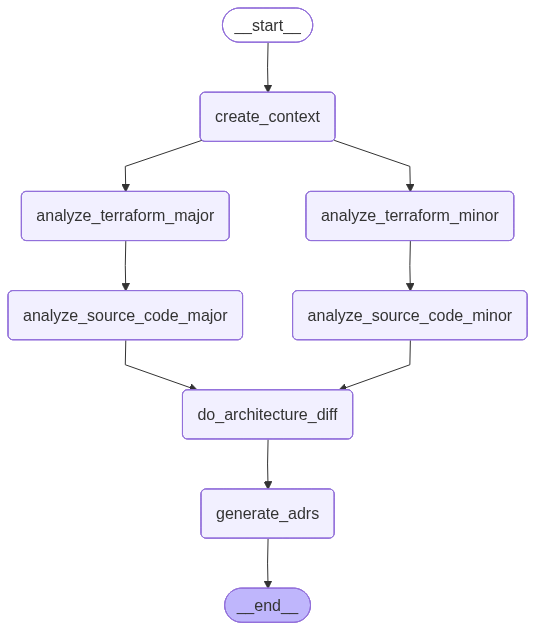

In [6]:
# Create the workflow graph
workflow = ADRWorkflow(project_dir)

initial_state = workflow.create(include_terraform=True, include_knowledge=True)

print("\nWorkflow created successfully!")
display(workflow.get_graph())

In [7]:
print("\nInitial state prepared:")
for key, value in initial_state.items():
    print(f"  {key}: {value}")



Initial state prepared:
  project_name: abelaa
  terraform_minor: ../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf
  terraform_major: ../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf
  source_code_zip_minor: 
  source_code_zip_major: ../project-inputs/abelaa/abelaa_app.zip
  knowledge_base: knowledge/IAC.txt
  timestamp: 2026-02-26T11:41:38.003565


---

In [8]:
result = await workflow.run(initial_state)
result

2026-02-26 11:43:24 - INFO - RUNNING workflow for project: ../project-inputs/abelaa - c0c482ae-5517-4149-9dcc-354dbf4f759c
2026-02-26 11:43:24 - INFO - STEP: context_generator_node
2026-02-26 11:43:24 - INFO - STEP: terraform_analyzer_major_node
2026-02-26 11:43:24 - WARNING - File not found: knowledge/IAC.txt
2026-02-26 11:43:24 - INFO - STEP: terraform_analyzer_minor_node
2026-02-26 11:43:24 - WARNING - File not found: knowledge/IAC.txt
2026-02-26 11:43:27 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-26 11:43:29 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-26 11:43:29 - INFO - STEP: source_code_analyzer_major_node
2026-02-26 11:43:29 - INFO - Source code found for major branch: ../project-inputs/abelaa/abelaa_app.zip
2026-02-26 11:43:29 - INFO - Extracted 2 files for major branch
2026-02-26 11:43:29 - INFO - STEP: source_code_analyzer_minor_node
2026-02-26 11:43:29 - WARNING - Sour

{'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf',
 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf',
 'source_code_zip_minor': '',
 'source_code_zip_major': '../project-inputs/abelaa/abelaa_app.zip',
 'knowledge_base': '',
 'architectural_context': '\n# Theoretical Introduction to Software Architecture, Monolithic Architecture, and Microservices Architecture\n\n## 1. Software Architecture\n\n### Definition\nSoftware architecture refers to the fundamental structures of a software system and the discipline of creating such structures and systems. It involves the high-level structuring of software components, their relationships, and the principles and guidelines governing their design and evolution over time.\n\n### Purpose and Importance\n- **Blueprint for Development:** Acts as a blueprint guiding the design and implementation of the system.\n- **Communication Tool:** Facilitates communication among stakeholders including devel

In [9]:
llm = get_llm_config().llm

---
## Individual Node Testing


In [12]:
# Test context generator node
print("\n--- Testing Context Generator Node ---")

context_result = await context_generator_node(initial_state, llm=llm)

print(f"Architectural context generated: {len(context_result['architectural_context'])} characters")
# print(f"Project structure extracted: {len(context_result['project_structure'])} characters")
print()

# display(Markdown(context_result['architectural_context']))
# display(Markdown(context_result['project_structure']))
# print(context_result['project_structure'])

context_result


--- Testing Context Generator Node ---
2026-02-26 13:13:35 - INFO - STEP: context_generator_node
Architectural context generated: 7145 characters



{'project_name': 'abelaa',
 'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf',
 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf',
 'source_code_zip_minor': '',
 'source_code_zip_major': '../project-inputs/abelaa/abelaa_app.zip',
 'knowledge_base': 'knowledge/IAC.txt',
 'timestamp': '2026-02-26T11:41:38.003565',
 'architectural_context': '\n# Theoretical Introduction to Software Architecture, Monolithic Architecture, and Microservices Architecture\n\n## 1. Software Architecture\n\n### Definition\nSoftware architecture refers to the fundamental structures of a software system and the discipline of creating such structures and systems. It involves the high-level structuring of software components, their relationships, and the principles and guidelines governing their design and evolution over time.\n\n### Purpose and Importance\n- **Blueprint for Development:** Acts as a blueprint guiding the design and implementation of the system.

In [13]:
# for k, v in context_result['source_code_dict'].items():
#     print("="*10+" "+k)
#     print(v)
#     print("="*20)

In [14]:
# display(Markdown(context_result['architectural_context'].strip()))
# print(context_result['architectural_context'].strip())


---

In [15]:
# path_knowledge_base = context_result['knowledge_base']
# context_result['knowledge_base'] = "../" +  path_knowledge_base if not path_knowledge_base.startswith("../") else path_knowledge_base


In [16]:
print("\n--- Testing Terraform Analyzer Minor Node ---")

terraform_result1 = await terraform_analyzer_minor_node(context_result, llm=llm)

# display(Markdown(context_result['terraform_analysis_minor']))
terraform_result1['terraform_analysis_minor']


--- Testing Terraform Analyzer Minor Node ---
2026-02-26 13:13:35 - INFO - STEP: terraform_analyzer_minor_node
2026-02-26 13:13:35 - WARNING - File not found: knowledge/IAC.txt
2026-02-26 13:13:40 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'microservices': False,
 'confidence': 0.85,
 'signals_for': ['Use of Terraform modules for modularity [C# module "covid-dev"]',
  'Use of AWS infrastructure components suggesting potential for distributed deployment [C# provider and remote state data]'],
 'signals_against': ['Single module deployment indicating a single application unit [C# module "covid-dev"]',
  'No evidence of multiple independent services or microservices modules [C# entire Terraform code]',
  'No explicit inter-service communication patterns such as APIs, messaging, or event-driven mechanisms [C# Terraform code]',
  'No indication of decentralized data management or multiple databases [C# Terraform code]',
  'Single deployment artifact implied by single module and single EC2 instance configuration [C# variables and module usage]']}

In [17]:
print("\n--- Testing Terraform Analyzer Major Node ---")

terraform_result2 = await terraform_analyzer_major_node(context_result, llm=llm)

# display(Markdown(context_result['terraform_analysis_major']))
terraform_result2['terraform_analysis_major']


--- Testing Terraform Analyzer Major Node ---
2026-02-26 13:13:40 - INFO - STEP: terraform_analyzer_major_node
2026-02-26 13:13:40 - WARNING - File not found: 
2026-02-26 13:13:49 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'microservices': False,
 'confidence': 0.9,
 'signals_for': ['Use of Terraform modules for infrastructure reuse [C# modules/pcmt-network and modules/pcmt]',
  'Multiple environment-specific Terraform configurations referencing shared modules and remote states [C# beta, demo, covid-dev, etc.]'],
 'signals_against': ['Single EC2 instance per deployment with no evidence of multiple independent services or containers [C# modules/pcmt compute.tf aws_instance.app]',
  'No explicit service decomposition or multiple independently deployable services in Terraform code [C# all main.tf and module usage]',
  'Communication is via DNS and Route53 records pointing to single IPs, no async messaging or API gateway patterns [C# modules/pcmt network.tf aws_route53_record]',
  'No orchestration or container management (e.g., ECS, EKS, Lambda) indicating distributed microservices [C# all]',
  'Deployment appears as single units per environment, not multiple independent deployables [C# demo, covid-dev, ma

---

In [18]:
print("\n--- Testing Source Code Analyzer Minor Node ---")

source_code_result1 = await source_code_analyzer_minor_node(context_result, llm=llm)

source_code_result1['improved_analysis_minor']


--- Testing Source Code Analyzer Minor Node ---
2026-02-26 13:13:49 - INFO - STEP: source_code_analyzer_minor_node
2026-02-26 13:13:49 - WARNING - Source code branch [minor] not available, using Terraform-only analysis


{'microservices': False,
 'confidence': 0.85,
 'signals_for': ['Use of Terraform modules for modularity [C# module "covid-dev"]',
  'Use of AWS infrastructure components suggesting potential for distributed deployment [C# provider and remote state data]'],
 'signals_against': ['Single module deployment indicating a single application unit [C# module "covid-dev"]',
  'No evidence of multiple independent services or microservices modules [C# entire Terraform code]',
  'No explicit inter-service communication patterns such as APIs, messaging, or event-driven mechanisms [C# Terraform code]',
  'No indication of decentralized data management or multiple databases [C# Terraform code]',
  'Single deployment artifact implied by single module and single EC2 instance configuration [C# variables and module usage]']}

In [19]:
# display(Markdown(context_result['improved_analysis_minor']))
# print(context_result['improved_analysis_minor']) #.strip('"')

In [20]:
print("\n--- Testing Source Code Analyzer Major Node ---")

source_code_result2 = await source_code_analyzer_major_node(context_result, llm=llm)

source_code_result2['improved_analysis_major']


--- Testing Source Code Analyzer Major Node ---
2026-02-26 13:13:50 - INFO - STEP: source_code_analyzer_major_node
2026-02-26 13:13:50 - INFO - Source code found for major branch: ../project-inputs/abelaa/abelaa_app.zip
2026-02-26 13:13:50 - INFO - Extracted 2 files for major branch
2026-02-26 13:14:53 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Architecture Analysis of the Given Solution\n\n---\n\n## 1. Project Structure and Codebase Organization\n\n### Overview\n\n- The project consists primarily of PHP source files, with no Python or Terraform files present in the provided source code.\n- The root directory contains `AppKernel.php` and a `config` directory with multiple YAML and PHP configuration files.\n- The `AppKernel.php` is a Symfony Kernel class, responsible for registering bundles (modules) and loading environment-specific configurations.\n- The configuration files (`config.yml`, `routing.yml`, `parameters.php`, etc.) follow Symfony’s standard conventions for environment-based configuration management.\n\n### Monolithic vs Modular\n\n- The codebase is organized as a **monolithic Symfony application**:\n  - All functionality is bundled into a single Symfony Kernel (`AppKernel.php`).\n  - Multiple bundles (Symfony’s modular units) are registered within this single kernel, but they are all loaded and deployed togethe

In [21]:
# display(Markdown(context_result['improved_analysis_major']))
# print(context_result['improved_analysis_major']) #.strip('"')

---

In [22]:
print("\n--- Testing Diff Analysis Node ---")

diff_result = await architecture_diff_node(context_result, llm=llm)

diff_result['architecture_diff']


--- Testing Diff Analysis Node ---
2026-02-26 13:14:53 - INFO - STEP: architecture_diff_node
2026-02-26 13:15:28 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Key Architecture Decisions in Migrating from Hybrid to Microservices Architecture\n\n---\n\n## 1. Architectural Decomposition: From Single Monolith to Multiple Independent Services\n\n**Description:**  \nThe migration involved decomposing the single monolithic application (hybrid version) into multiple independently deployable microservices, each implemented as separate Lambda functions.\n\n**Key Differences Necessitating This Decision:**  \n- Hybrid version is a single deployment unit with tightly coupled components and a single Lambda function alongside a monolith.  \n- Microservices version splits functionality into multiple Lambda functions, each encapsulating a distinct business capability or service boundary.  \n- The microservices version introduces an API Gateway to route requests to these independent services.\n\n**Architectural Impact:**  \n- Enables independent development, deployment, and scaling of services.  \n- Improves fault isolation; failure in one service does not

In [23]:
# display(Markdown(context_result['architecture_diff']))
# print(context_result['architecture_diff']) #.strip('"')

---

In [24]:
print("\n--- Testing ADR Generation Node ---")

adr_result = await adr_generator_node(context_result, llm=llm)

adr_result['adr_files']


--- Testing ADR Generation Node ---
2026-02-26 13:15:28 - INFO - STEP: adr_generator_node
2026-02-26 13:17:16 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'abelaa_ADR_1.md': '# ADR: Architectural Decomposition\n\n## Title\nDecompose Monolithic Application into Independent Microservices\n\n## Status\nAccepted\n\n## Motivation\nThe existing hybrid architecture consists of a single monolithic application combined with a single Lambda function, resulting in tightly coupled components and a single deployment unit. This structure limits scalability, fault isolation, and independent deployment capabilities. To address these limitations and improve agility, scalability, and resilience, it is necessary to decompose the monolith into multiple independently deployable services, each encapsulating distinct business capabilities.\n\n## Decision Drivers\n- Need for independent development and deployment of components\n- Requirement for improved fault isolation to prevent cascading failures\n- Scalability demands requiring fine-grained scaling of services\n- Desire to reduce coupling and improve maintainability\n- Organizational need to align teams ar

In [25]:
# context_result = result

# folder_path = Path("../output-adrs/"+project_config['project_name'])
# folder_path.mkdir(parents=True, exist_ok=True) 

for k,adr in context_result['adr_files'].items():
    print("="*10+" "+k)
    display(Markdown(adr))
    print(("="*30))
    print()
    # with (folder_path / k).open("w") as file:
    #     file.write(adr)

    # print(f"File '{k}' written to '{folder_path}'")

========== abelaa_ADR_1.md


# ADR: Architectural Decomposition

## Title
Decompose Monolithic Application into Independent Microservices

## Status
Accepted

## Motivation
The existing hybrid architecture consists of a single monolithic application combined with a single Lambda function, resulting in tightly coupled components and a single deployment unit. This structure limits scalability, fault isolation, and independent deployment capabilities. To address these limitations and improve agility, scalability, and resilience, it is necessary to decompose the monolith into multiple independently deployable services, each encapsulating distinct business capabilities.

## Decision Drivers
- Need for independent development and deployment of components
- Requirement for improved fault isolation to prevent cascading failures
- Scalability demands requiring fine-grained scaling of services
- Desire to reduce coupling and improve maintainability
- Organizational need to align teams around business capabilities

## Main Decision
The architecture will be decomposed from a single monolithic application into multiple independent microservices, each implemented as separate AWS Lambda functions. An API Gateway will be introduced to route requests to these services, establishing clear service boundaries and contracts. This approach enables independent development, deployment, and scaling of each service, improving fault isolation and agility while increasing architectural complexity due to distributed components and inter-service communication.

## Alternatives
- Monolithic Architecture: Retain the single unified application with tightly coupled components and a single deployment unit
- Modular Monolith: Maintain modular code structure within a single deployable unit without independent service deployment

## Pros
Main decision:
- Enables independent scaling and deployment of services
- Improves fault isolation by isolating failures to individual services
- Facilitates parallel development and faster delivery cycles
- Aligns architecture with business capabilities

Monolithic Architecture:
- Simpler initial development and deployment
- Lower operational complexity
- Faster in-process communication

Modular Monolith:
- Maintains modularity and code organization
- Easier to test end-to-end within a single process
- Avoids complexity of distributed systems

## Cons
Main decision:
- Increases architectural and operational complexity
- Requires management of service boundaries and inter-service communication
- Necessitates robust API design and versioning

Monolithic Architecture:
- Limits scalability and fault isolation
- Slower development cycles as codebase grows
- Difficult to adopt new technologies incrementally

Modular Monolith:
- Does not enable independent deployment or scaling
- Still suffers from tight coupling at runtime
- Limits organizational agility

## Consequences
Short-term, the decomposition increases complexity and requires investment in defining service boundaries, API contracts, and deployment pipelines. Long-term, it improves scalability, fault tolerance, maintainability, and organizational agility. The architecture gains resilience by isolating faults and enabling independent scaling. However, it introduces challenges in managing distributed systems, including inter-service communication, monitoring, and deployment orchestration.

## Validation
Validation can be performed through incremental refactoring and extraction of services, monitoring deployment and scaling behavior, and assessing fault isolation during failure scenarios. Pilot implementations of key services as independent Lambda functions with API Gateway routing can validate the approach before full migration.

## Additional Information



========== abelaa_ADR_2.md


# ADR: Communication Style

## Title
Adopt Networked API Gateway and RESTful Service Communication

## Status
Accepted

## Motivation
The hybrid architecture relies on in-process method calls within a single runtime environment, which is efficient but tightly couples components and limits scalability and fault isolation. Migrating to microservices necessitates inter-service communication over the network. To enable independent deployment and scaling of services, a robust communication mechanism is required that supports clear service interfaces, security, and versioning.

## Decision Drivers
- Requirement for independent service deployment and scaling
- Need for clear and explicit service interfaces
- Security requirements including authentication and authorization
- Necessity to handle network latency and potential communication failures
- Desire to enable API versioning and monitoring

## Main Decision
The architecture will adopt an API Gateway to mediate all client requests and route them to individual microservices implemented as Lambda functions exposing RESTful APIs. This networked communication style replaces in-process calls with HTTP-based interactions, enabling service independence and scalability. The API Gateway also centralizes concerns such as authentication, authorization, and request routing, facilitating robust API management.

## Alternatives
- In-Process Calls: Retain method calls within a single runtime environment as in the monolith
- Message-Based Communication: Use asynchronous messaging or event-driven communication between services

## Pros
Main decision:
- Enables independent scaling and deployment of services
- Centralizes API management, security, and routing via API Gateway
- Supports standard RESTful interfaces facilitating interoperability
- Enables monitoring and versioning of APIs

In-Process Calls:
- Low latency and high performance
- Simpler communication without network overhead

Message-Based Communication:
- Decouples services asynchronously
- Improves resilience and scalability
- Enables event-driven architectures

## Cons
Main decision:
- Introduces network latency and potential points of failure
- Increases complexity in error handling and retries
- Requires robust API design and security mechanisms

In-Process Calls:
- Tightly couples components
- Limits independent deployment and scaling
- Not feasible in distributed microservices

Message-Based Communication:
- Adds complexity in eventual consistency and message handling
- Requires additional infrastructure and operational overhead
- Increases testing complexity

## Consequences
This decision introduces network communication overhead and potential failure points, requiring robust error handling, monitoring, and security. It enables independent service evolution and scaling but demands investment in API design, versioning, and operational tooling. The architecture gains flexibility and resilience but must manage increased complexity inherent in distributed systems.

## Validation
Validation includes performance benchmarking of API Gateway routing, security testing of authentication and authorization mechanisms, and monitoring of inter-service communication reliability. Prototyping RESTful APIs and simulating failure scenarios can validate robustness.

## Additional Information



========== abelaa_ADR_3.md


# ADR: Deployment Model

## Title
Deploy as Independent Serverless Lambda Functions

## Status
Accepted

## Motivation
The hybrid architecture deploys a single monolithic artifact alongside one Lambda function, limiting scalability and agility. To fully realize the benefits of microservices, each service must be independently deployable and scalable. Serverless deployment using AWS Lambda functions allows fine-grained resource allocation, reduces operational overhead, and supports event-driven architectures, aligning with the microservices paradigm.

## Decision Drivers
- Need for independent deployment and scaling of services
- Desire to reduce operational overhead and server management
- Requirement for event-driven, scalable infrastructure
- Necessity for automation and CI/CD pipelines supporting multiple deployments
- Organizational goals for agility and faster delivery

## Main Decision
Each microservice will be packaged and deployed as an independent AWS Lambda function. This serverless deployment model eliminates the need for managing servers, enables automatic scaling per service, and supports event-driven invocation patterns. Deployment pipelines will be enhanced to automate packaging, testing, and deployment of multiple Lambda functions independently, facilitating continuous delivery and operational agility.

## Alternatives
- Single Deployment Artifact: Deploy all services as a single monolithic artifact
- Containerized Microservices: Deploy services as containers managed by orchestration platforms

## Pros
Main decision:
- Enables fine-grained scaling and resource allocation
- Reduces operational overhead related to server management
- Supports event-driven and on-demand execution
- Facilitates independent deployment and faster release cycles

Single Deployment Artifact:
- Simpler deployment process
- Easier to manage a single artifact

Containerized Microservices:
- Provides more control over runtime environment
- Supports complex service dependencies
- Enables portability across environments

## Cons
Main decision:
- Increases complexity in deployment orchestration and version management
- Requires sophisticated CI/CD pipelines
- Potential cold start latency in Lambda functions

Single Deployment Artifact:
- Limits scalability and fault isolation
- Slower deployment cycles
- Higher operational overhead for scaling

Containerized Microservices:
- Requires container orchestration infrastructure
- Higher operational complexity than serverless
- Increased resource consumption

## Consequences
The serverless deployment model improves scalability, reduces operational burden, and accelerates delivery. However, it introduces challenges such as managing multiple deployment artifacts, handling cold starts, and ensuring consistent monitoring and logging across functions. Long-term, this approach supports agile development and efficient resource utilization but requires investment in automation and operational tooling.

## Validation
Validation includes deployment of pilot Lambda functions, monitoring scaling behavior and cold start performance, and verifying CI/CD pipeline effectiveness. Load testing and failure injection can assess resilience and operational readiness.

## Additional Information



========== abelaa_ADR_4.md


# ADR: Data Management Strategy

## Title
Adopt Decentralized Data Ownership per Microservice

## Status
Accepted

## Motivation
The hybrid architecture uses a shared centralized database accessed by the monolith and Lambda function, resulting in tight coupling at the data layer and limiting service autonomy. To enable true microservice independence and loose coupling, each service must own and manage its own data store. This approach supports independent scaling and evolution but introduces challenges in maintaining data consistency across services.

## Decision Drivers
- Requirement for service autonomy and loose coupling
- Need to enable independent scaling and optimization of data stores
- Challenges in distributed transactions and data consistency
- Necessity to design for eventual consistency and data synchronization
- Organizational goals for scalability and maintainability

## Main Decision
Each microservice will own and manage its own data persistence layer, eliminating the shared centralized database. This decentralized data ownership enforces loose coupling at the data layer, allowing services to evolve independently and scale their data stores as needed. To address consistency challenges, eventual consistency patterns and data synchronization mechanisms will be designed and implemented where necessary.

## Alternatives
- Shared Centralized Database: Continue using a single database accessed by all services
- Database per Service with Synchronous Transactions: Attempt distributed transactions across services

## Pros
Main decision:
- Improves service autonomy and loose coupling
- Enables independent scaling and optimization of data stores
- Facilitates independent evolution of data schemas

Shared Centralized Database:
- Simplifies data consistency and transactions
- Easier to query across domains

Database per Service with Synchronous Transactions:
- Attempts strong consistency across services
- Simplifies some business logic requiring atomicity

## Cons
Main decision:
- Introduces complexity in maintaining data consistency
- Requires design of eventual consistency and synchronization
- Increases operational complexity managing multiple data stores

Shared Centralized Database:
- Creates tight coupling between services
- Limits independent scaling and deployment
- Increases risk of cascading failures

Database per Service with Synchronous Transactions:
- Distributed transactions are complex and error-prone
- Can degrade performance and scalability
- Difficult to implement reliably in distributed systems

## Consequences
Decentralized data ownership enhances scalability, maintainability, and service autonomy but requires careful design of data consistency and synchronization mechanisms. It increases operational complexity and demands robust monitoring and testing strategies. Long-term, this approach aligns with microservices principles and supports organizational agility.

## Validation
Validation involves designing and testing eventual consistency patterns, implementing data synchronization mechanisms, and monitoring data integrity during service interactions. Prototyping data ownership boundaries and consistency models can validate feasibility.

## Additional Information



========== abelaa_ADR_5.md


# ADR: Migration Strategy

## Title
Incremental Modularization and Refactoring of Monolith into Microservices

## Status
Accepted

## Motivation
The existing hybrid architecture is a modular monolith with bundles but lacks independent deployability. Migrating directly to microservices requires clear service boundaries and extraction of functionality into separate deployable units. To minimize disruption and risk, an incremental migration strategy is necessary to gradually refactor and modularize the monolith into independent microservices.

## Decision Drivers
- Need to minimize disruption to existing functionality during migration
- Requirement to identify bounded contexts and service boundaries
- Desire to leverage domain-driven design principles
- Organizational constraints on development resources and timelines
- Necessity to maintain system stability and continuity

## Main Decision
The migration will proceed incrementally by modularizing and refactoring the monolithic codebase into well-defined components that can be extracted as independent microservices. This approach involves identifying bounded contexts, defining clear service boundaries, and progressively extracting functionality into separate Lambda functions. This strategy reduces risk, allows parallel development, and facilitates continuous delivery throughout the migration process.

## Alternatives
- Big Bang Migration: Rewrite and deploy the entire system as microservices in a single effort
- Parallel Systems: Develop microservices alongside the monolith and switch over once complete

## Pros
Main decision:
- Minimizes disruption and risk during migration
- Allows gradual learning and adaptation
- Supports continuous delivery and parallel development
- Enables early validation of microservices

Big Bang Migration:
- Potentially faster transition if successful
- Clean break from legacy architecture

Parallel Systems:
- Allows coexistence of old and new systems
- Enables gradual cutover and rollback options

## Cons
Main decision:
- Requires careful planning and coordination
- May prolong migration timeline
- Demands investment in testing and integration

Big Bang Migration:
- High risk of failure and disruption
- Difficult to manage and test large changes

Parallel Systems:
- Increased operational complexity
- Potential data synchronization challenges
- Higher resource requirements

## Consequences
The incremental migration strategy balances risk and agility, enabling continuous delivery and minimizing downtime. It requires investment in defining service boundaries, testing strategies, and integration mechanisms. Long-term, it facilitates a smooth transition to microservices with improved maintainability and scalability.

## Validation
Validation includes monitoring system stability during incremental refactoring, assessing deployment success rates, and gathering feedback from development teams. Pilot extractions of services can validate the approach before broader adoption.

## Additional Information


---